# Anomality detection results


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Trained w/ ASD


In [52]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder,
        # "anomality_detection_arotor_replication",
        # "anomality_detection_arotor_replication_acc3",
        "anomality_detection_arotor_replication_acc3_32",
        # "anomality_detection_arotor_replication_acc3_32_norm",
        "support_10.feather",
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder,
        # "anomality_detection_arotor_replication",
        # "anomality_detection_arotor_replication_acc3",
        "anomality_detection_arotor_replication_acc3_32",
        # "anomality_detection_arotor_replication_acc3_32_norm",
        "query_10.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (3410, 35)
query (30607, 37)


In [53]:
rpm = 1500
torque = 1
support_GP = [1, 2, 3, 4]
query_GP = ["5", "6", "7", "8", "9"]
# query_GP = ["8"]
severity = "severe"
# installation = [1]
installation = [1, 2]
faults = ["micropitting", "pitting", "wear", "tff"]

# SUPPORT #
support_group = support_data[
    (support_data["rpm"] == rpm)
    & (support_data["GP"].isin(support_GP))
    & (support_data["torque"] == torque)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

# QUERY #
query_groups = []

# Baseline
query_group = query_data[
    (query_data["rpm"] == rpm)
    & (query_data["severity"].isin(query_GP))
    & (query_data["torque"] == torque)
    & (query_data["installation"] == 0)  # All baseline in installation 0
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group = query_group.to_numpy()
query_groups.append(query_group)

# Faults
for fault in faults:
    query_group = query_data[
        (query_data["rpm"] == rpm)
        & (query_data["severity"] == severity)
        & (query_data["torque"] == torque)
        & (query_data["installation"].isin(installation))
        & (query_data["fault"] == fault)
    ].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
    query_group = query_group.to_numpy()

    query_groups.append(query_group)

### Distances


SUPPORT
Mean: 8.296352
Max: 26.970432
Min: 1.0087823

Healthy
Mean: 23.452068
Max: 68.21785
Min: 4.0103774
Micropitting
Mean: 22.866556
Max: 60.836548
Min: 5.5007353
Pitting
Mean: 30.28096
Max: 93.81321
Min: 6.0327063
Wear
Mean: 35.384083
Max: 75.84904
Min: 9.414007
TFF
Mean: 147.5465
Max: 394.11166
Min: 64.952835


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_91810/1059662015.py:32: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.catplot(


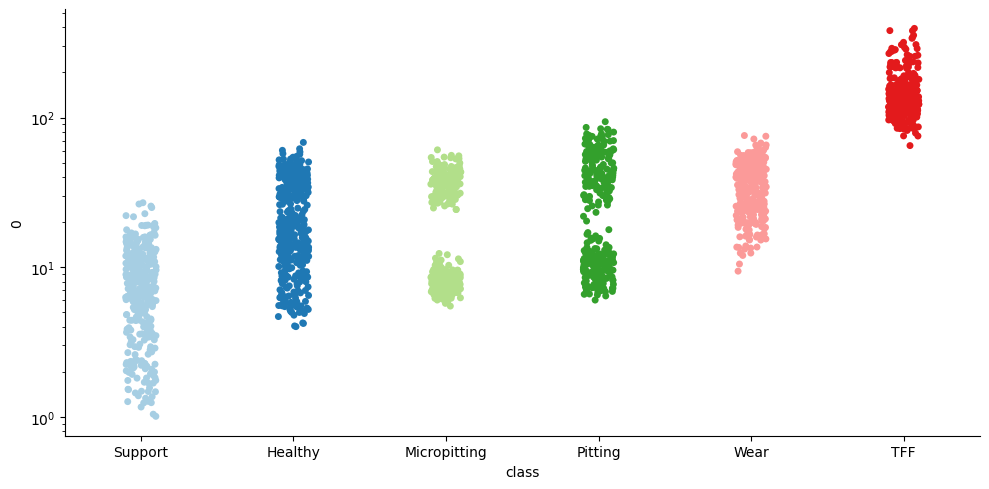

In [51]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
for i in range(5):
    print(fault_map[i])
    query_distances[fault_map[i]] = np.sum((query_groups[i] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

SUPPORT
Mean: 1522343.9
Max: 6191794.0
Min: 46746.77

Healthy
Mean: 10460841.0
Max: 38027428.0
Min: 269589.03
Micropitting
Mean: 27352724.0
Max: 61268610.0
Min: 558224.3
Pitting
Mean: 17045154.0
Max: 31265428.0
Min: 3238719.5
Wear
Mean: 3931827.8
Max: 7072125.5
Min: 883598.2
TFF
Mean: 108376936.0
Max: 287111580.0
Min: 36135420.0


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_91810/1059662015.py:32: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.catplot(


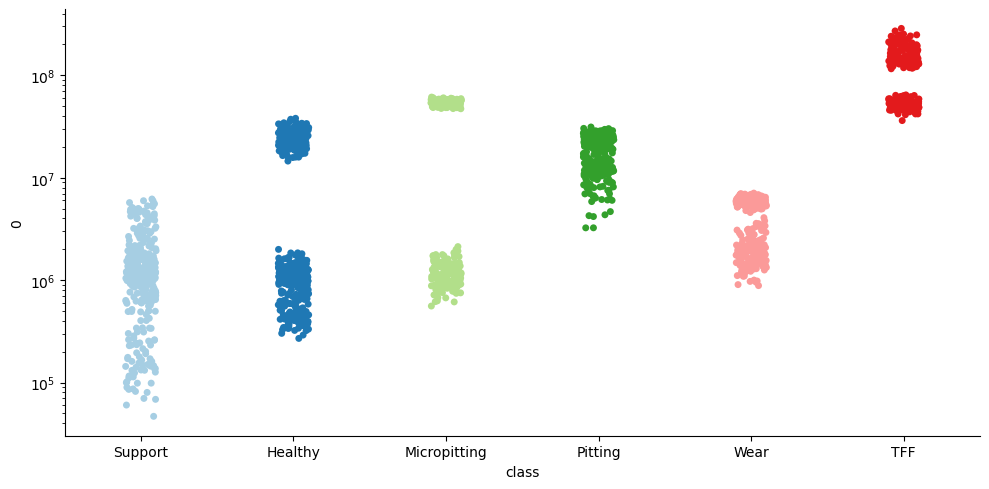

In [54]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
for i in range(5):
    print(fault_map[i])
    query_distances[fault_map[i]] = np.sum((query_groups[i] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

### 2D TSNE


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/3182773687.py:19: UserWarning:

The palette list has more values (10) than needed (6), which may not be intended.



<Axes: xlabel='x', ylabel='y'>

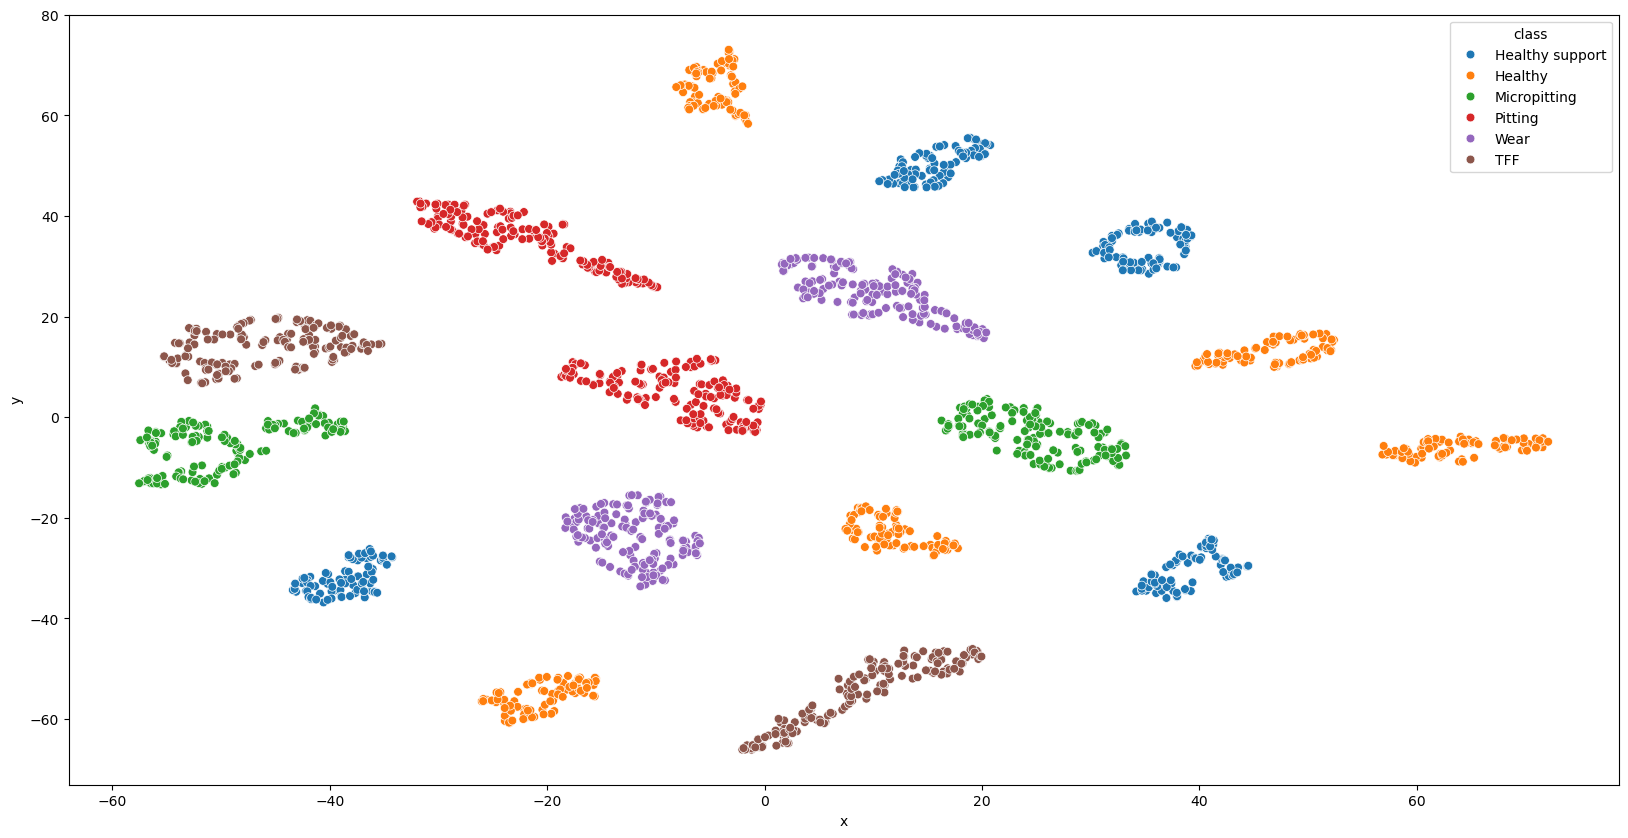

In [36]:
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *query_groups]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

### 3D TSNE


In [37]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *query_groups]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.show()

### 3D PCA


In [38]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(np.concatenate([support_group, *query_groups]))

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()

# Trained w/ AGFD


In [27]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder,
        "anomality_detection_arotor_12-12_17-38-52",
        "support_0.feather",
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder,
        "anomality_detection_arotor_12-12_17-38-52",
        "query_0.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (208, 18)
query (3952, 18)


In [28]:
rpm = 1500

# SUPPORT #

support_group = support_data[(support_data["rpm"] == rpm)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

# QUERY #

query_groups = {}

for i in range(10):
    query_group = query_data[
        (query_data["rpm"] == rpm) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()

### 2D TSNE


(52, 16)
(104, 16)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/2370985312.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

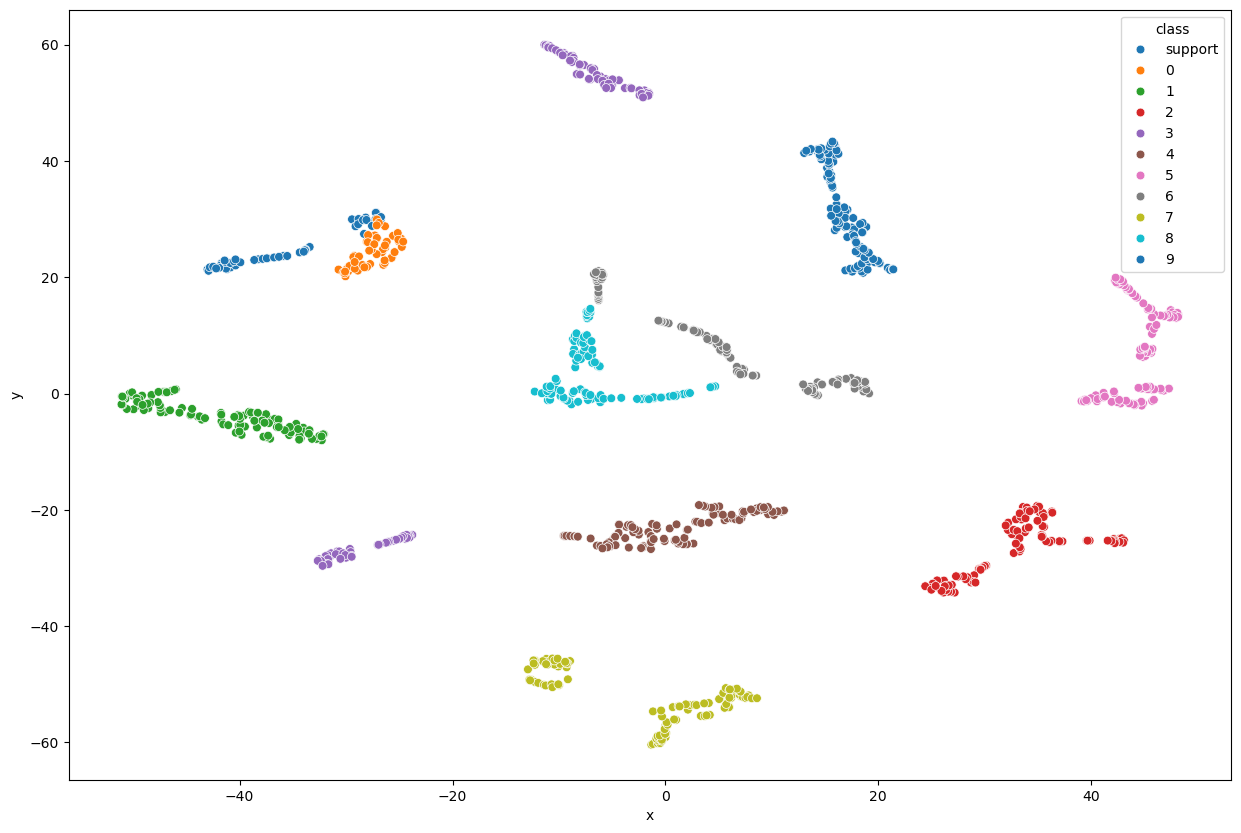

In [29]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

### 3D TSNE


In [30]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

### 3D PCA


In [31]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

### Distances


SUPPORT
Mean: 16.93671
Max: 42.94537
Min: 1.0246133

0
Mean: 19.827328
Max: 39.675175
Min: 7.8753076
1
Mean: 1704.935
Max: 2164.3118
Min: 1250.8705
2
Mean: 4294.254
Max: 5830.092
Min: 3456.9822
3
Mean: 64093.36
Max: 85749.18
Min: 51463.008
4
Mean: 5297.435
Max: 7478.2627
Min: 3572.6733
5
Mean: 43555.9
Max: 54491.246
Min: 30182.012
6
Mean: 87081.516
Max: 104941.445
Min: 65232.098
7
Mean: 7902.1694
Max: 9748.569
Min: 6217.2466
8
Mean: 81551.71
Max: 93068.94
Min: 74672.695
9
Mean: 198619.6
Max: 217978.33
Min: 175300.52


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/3057055446.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



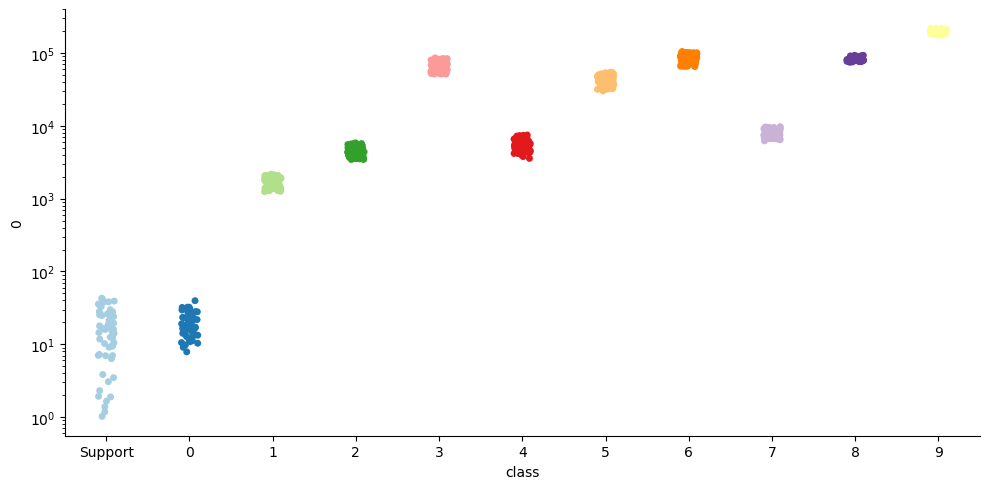

In [32]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)

---

# OLD


# ARotor replication


In [17]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    # os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "support_0.feather")
    os.path.join(
        data_folder,
        "anomality_detection_arotor_replication_10-25_12-55-17",
        "support_0.feather",
    )
)
query_data = pd.read_feather(
    # os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "query_0.feather")
    os.path.join(
        data_folder,
        "anomality_detection_arotor_replication_10-25_12-55-17",
        "query_0.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (3410, 67)
query (30607, 69)


## Figures


In [18]:
support_group = support_data[
    (support_data["rpm"] == 1500)
    & (support_data["GP"].isin([1, 2, 3, 4]))
    & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group = query_group.to_numpy()

query_group_2 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_2 = query_group_2.to_numpy()

query_group_3 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_3 = query_group_3.to_numpy()

query_group_4 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_4 = query_group_4.to_numpy()

query_group_5 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_5 = query_group_5.to_numpy()

query_group_6 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "8")
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_6 = query_group_6.to_numpy()

/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/3833122620.py:18: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



<Axes: xlabel='x', ylabel='y'>

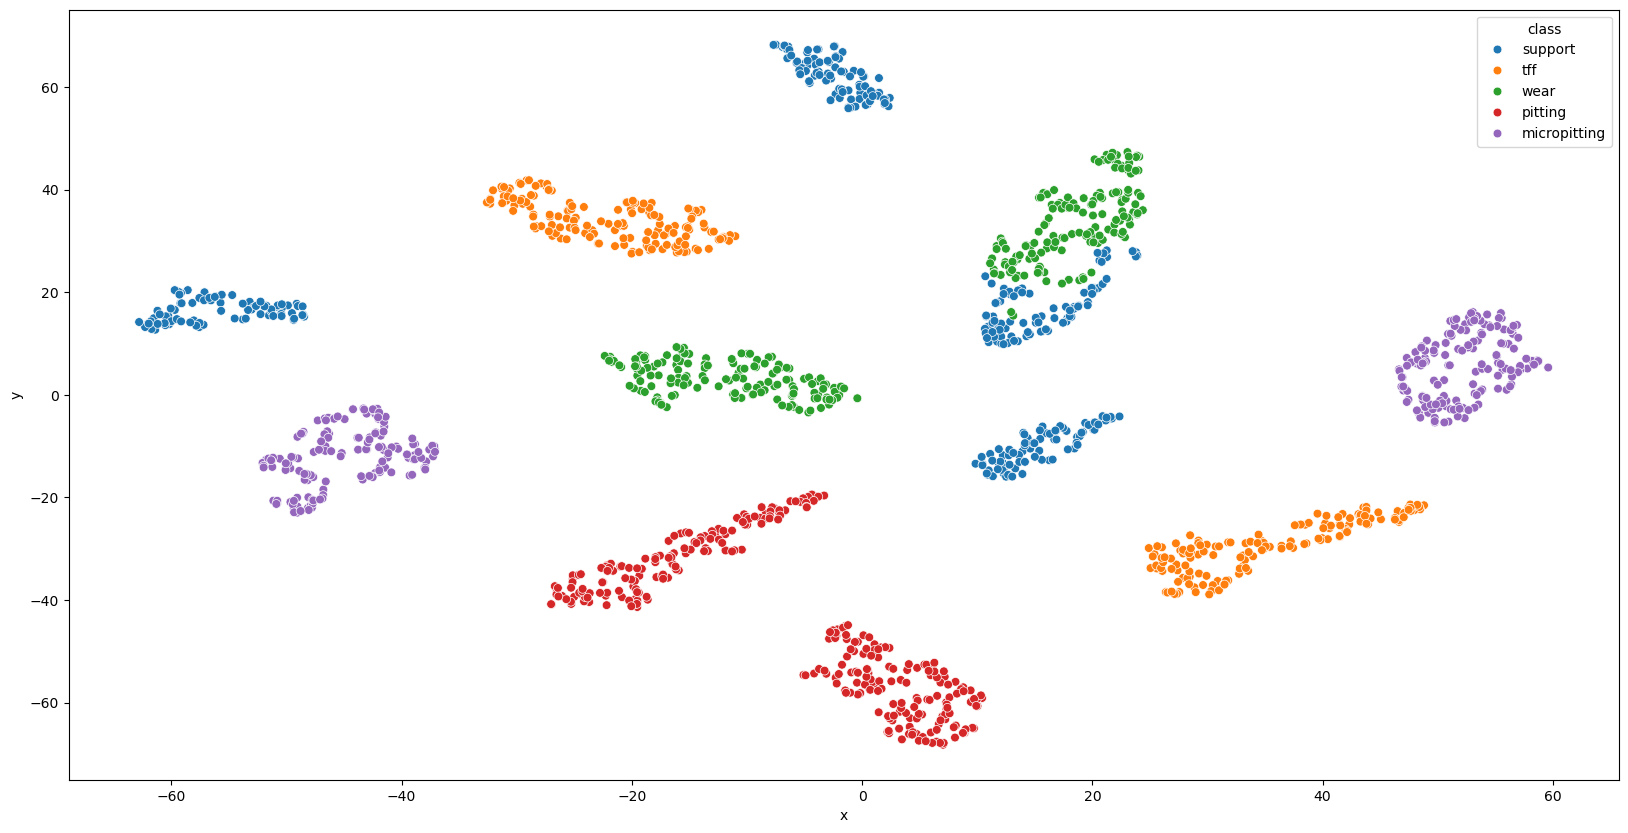

In [19]:
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_group, query_group, query_group_2, query_group_3, query_group_4]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

In [20]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_group, query_group, query_group_2, query_group_3, query_group_4]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.show()

In [21]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(
    np.concatenate(
        [
            support_group,
            query_group_6,
            query_group,
            query_group_2,
            query_group_3,
            query_group_4,
            query_group_5,
        ]
    )
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group_6) * ["healthy"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
        len(query_group_5) * ["mild tff"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()

## Distance thresholding


In [22]:
support_group = support_data[
    (support_data["rpm"] == 1500)
    & (support_data["GP"].isin([1, 2, 3, 4]))
    & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = {}

query_group_baseline = query_data[
    (query_data["rpm"] == 1500)
    # & (query_data["severity"].isin(["5", "8", "9"]))
    # ! FIXME GPs 6 and 7 problematic why?
    & (query_data["severity"].isin(["5", "6", "7", "8", "9"]))
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["baseline"] = query_group_baseline.to_numpy()

query_group_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["tff"] = query_group_tff.to_numpy()

query_group_mild_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["mild_tff"] = query_group_mild_tff.to_numpy()

query_group_wear = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["wear"] = query_group_wear.to_numpy()

query_group_pitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["pitting"] = query_group_pitting.to_numpy()

query_group_micropitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["micropitting"] = query_group_micropitting.to_numpy()

### Raw distance


SUPPORT
Mean: 284203.4
Max: 794919.9
Min: 64831.215

baseline
Mean: 2686348.2
Max: 9524642.0
Min: 81452.74
mild_tff
Mean: 1466611.5
Max: 2343536.2
Min: 599408.06
tff
Mean: 42701184.0
Max: 135601070.0
Min: 13163798.0
micropitting
Mean: 8532213.0
Max: 18324992.0
Min: 1161437.8
pitting
Mean: 5623113.5
Max: 9232406.0
Min: 1763113.6
wear
Mean: 350861.34
Max: 731612.44
Min: 64104.336


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/2274576752.py:31: UserWarning:

The palette list has more values (12) than needed (7), which may not be intended.



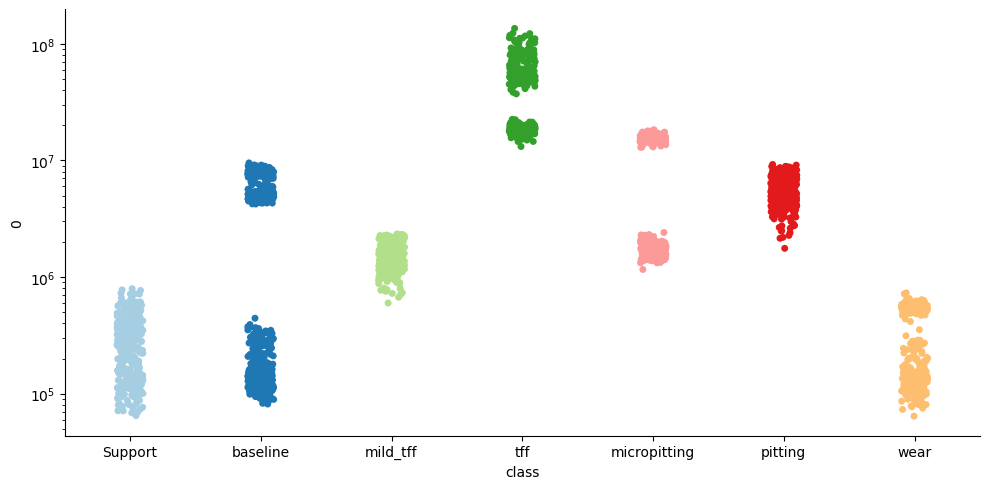

In [23]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum((query_group[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

### STD scaled distance


SUPPORT
Mean: 63.853104
Max: 245.57063
Min: 15.81571

baseline
Mean: 513.15875
Max: 1723.5696
Min: 26.33206
mild_tff
Mean: 250.26807
Max: 417.69586
Min: 98.74089
tff
Mean: 21661.05
Max: 37699.156
Min: 12174.85
micropitting
Mean: 1662.2854
Max: 3562.3071
Min: 180.07896
pitting
Mean: 1104.7709
Max: 1902.5264
Min: 314.42163
wear
Mean: 92.59843
Max: 182.37373
Min: 18.066534


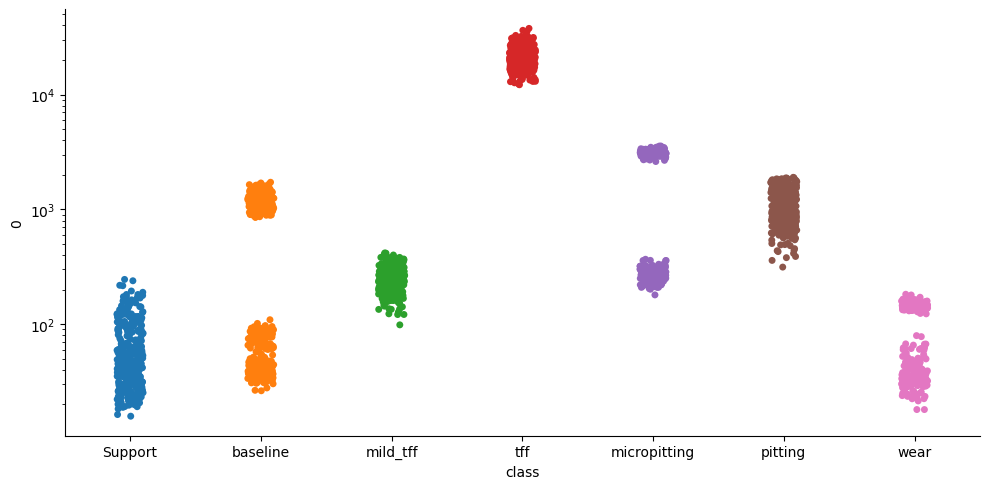

In [24]:
prototype = support_group.mean(axis=0)
prototype_std = support_group.std(axis=0)

prototype_std += 0.01  # Some stds are 0

print("SUPPORT")
support_distances = np.sum(((support_group - prototype) / prototype_std) ** 2, axis=1)
# support_distances = support_distances / prototype_std
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(
        ((query_group[fault] - prototype) / prototype_std) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)

### Distance after PCA


(341, 5)
(5,)
SUPPORT
Mean: 282891.8
Max: 790609.75
Min: 63715.84

baseline
Mean: 2668191.0
Max: 9465446.0
Min: 79221.07

mild_tff
Mean: 1455084.9
Max: 2324417.8
Min: 591030.44

tff
Mean: 41453290.0
Max: 130277970.0
Min: 12678226.0

micropitting
Mean: 8494871.0
Max: 18259750.0
Min: 1153664.5

pitting
Mean: 5602508.0
Max: 9211996.0
Min: 1749229.9

wear
Mean: 343125.97
Max: 719074.6
Min: 62858.652



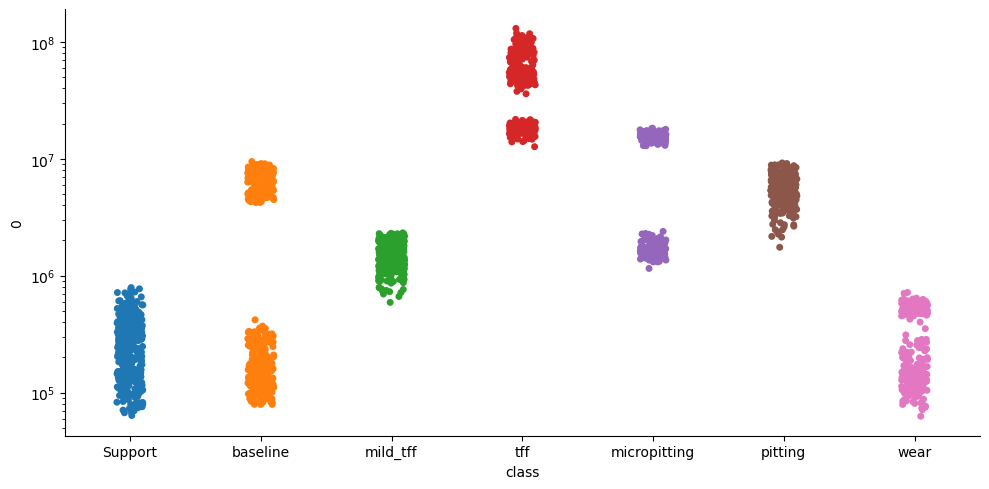

In [25]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(
        (pca.transform(query_group[fault]) - prototype) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)

# ARotor


In [11]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder, "anomality_detection_arotor_10-18_17-35-55", "support_0.feather"
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder, "anomality_detection_arotor_10-18_17-35-55", "query_0.feather"
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (208, 66)
query (3952, 66)


In [12]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

query_groups = {}

for i in range(10):
    query_group = query_data[
        (query_data["rpm"] == 1500) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()

(52, 64)
(104, 64)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/1751696896.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

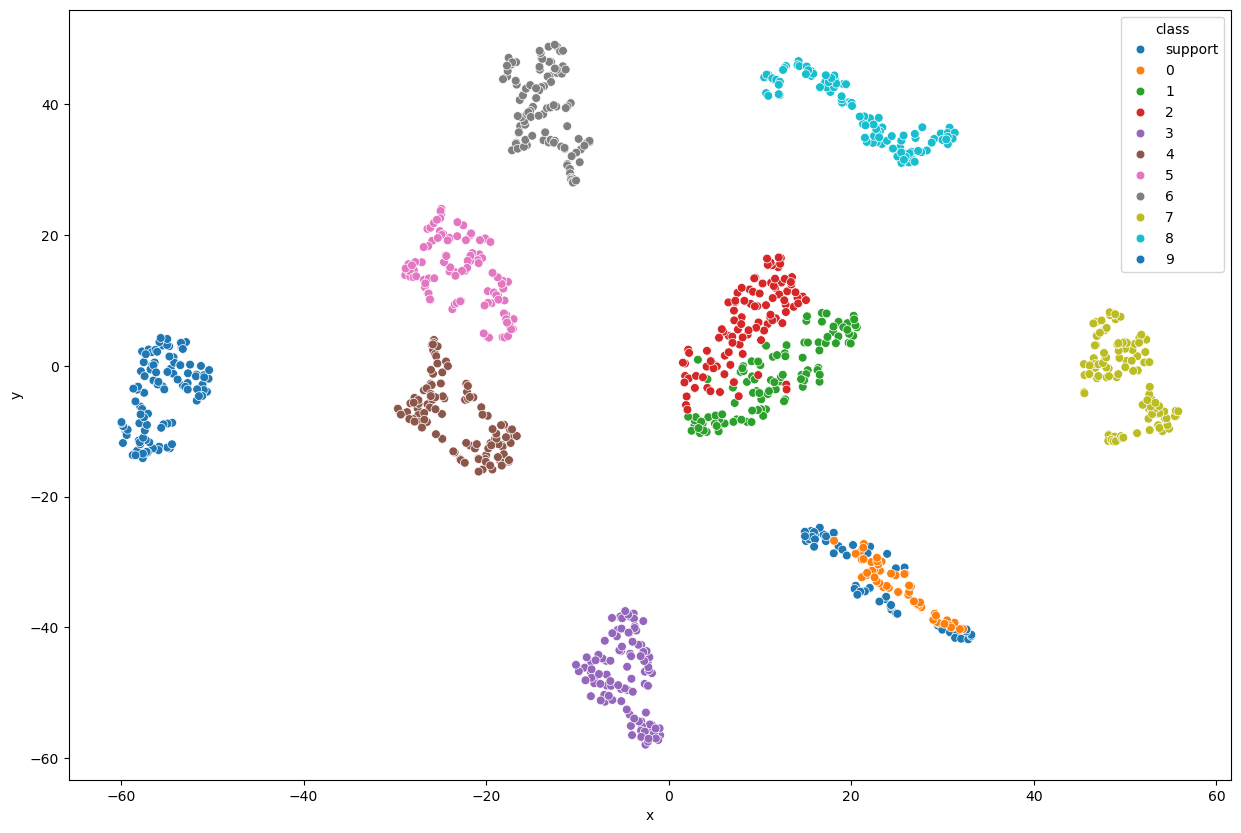

In [13]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

In [ ]:
str(sns.color_palette().as_hex())

"['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']"

### Distances


In [ ]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

query_group = {}

for i in range(10):
    query_group_baseline = query_data[
        (query_data["rpm"] == 1500) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_group["baseline"] = query_group_baseline.to_numpy()

SUPPORT
Mean: 6542.1953
Max: 30318.348
Min: 863.4813

0
Mean: 3713.5776
Max: 12462.372
Min: 1637.6204
1
Mean: 4100191.5
Max: 5851580.5
Min: 3012762.5
2
Mean: 4396277.0
Max: 6185351.5
Min: 3020712.0
3
Mean: 1794723.2
Max: 2658541.0
Min: 1046323.3
4
Mean: 184759.08
Max: 486035.88
Min: 98558.4
5
Mean: 470167.78
Max: 906059.9
Min: 184549.25
6
Mean: 928152.94
Max: 1499536.9
Min: 396398.88
7
Mean: 241784.47
Max: 411656.22
Min: 87098.234
8
Mean: 532484.8
Max: 818234.75
Min: 352948.75
9
Mean: 1229076.9
Max: 1843879.2
Min: 853211.1


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_56158/3284075337.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



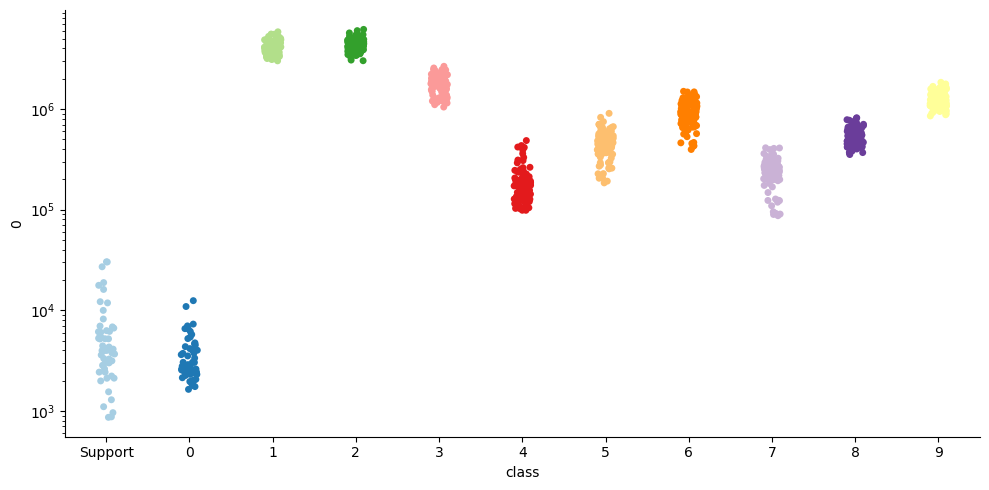

In [ ]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)

(52, 5)
(5,)
SUPPORT
Mean: 6171.154
Max: 30053.492
Min: 557.91754

0
Mean: 2737.9983
Max: 11904.995
Min: 675.12946

1
Mean: 3810128.2
Max: 5371965.0
Min: 2813731.0

2
Mean: 4028095.5
Max: 5539995.0
Min: 2785049.0

3
Mean: 1663222.6
Max: 2454545.0
Min: 979221.3

4
Mean: 168045.5
Max: 458705.03
Min: 84806.29

5
Mean: 425348.7
Max: 806707.44
Min: 166935.22

6
Mean: 771405.9
Max: 1308005.4
Min: 326110.62

7
Mean: 210900.72
Max: 371079.72
Min: 76442.47

8
Mean: 351590.8
Max: 626976.1
Min: 205615.33

9
Mean: 816633.75
Max: 1276034.9
Min: 562547.8



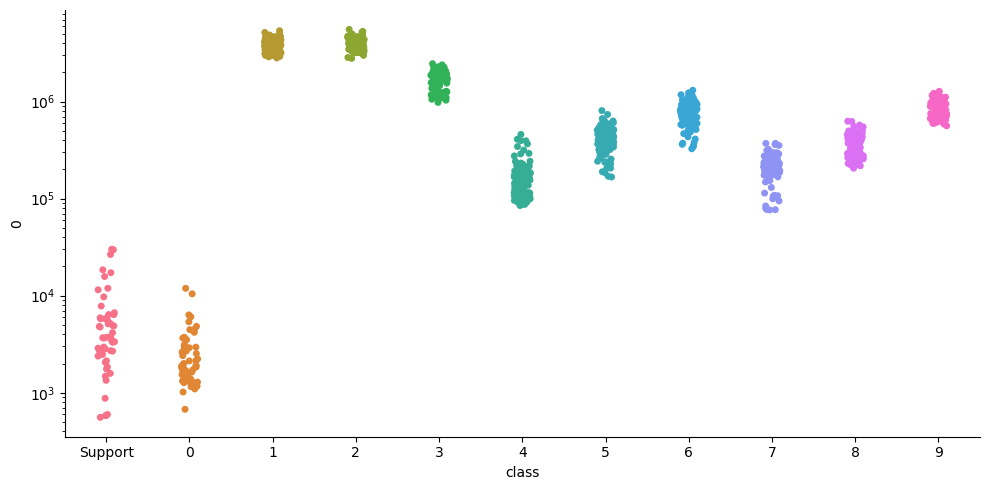

In [ ]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum(
        (pca.transform(query_groups[fault]) - prototype) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)